In [1]:
# Movie Review Sentiment Analysis using SVM
# Project: Sentiment Classification with Support Vector Machine

# ============================================================================
# SECTION 1: SETUP AND INSTALLATIONS
# ============================================================================

# Install required packages (run this cell first in Colab)
!pip install -q scikit-learn pandas numpy matplotlib seaborn

import os
import re
import tarfile
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

print("All packages imported successfully!")

All packages imported successfully!


In [2]:
# ============================================================================
# SECTION 2: DATA COLLECTION AND LOADING
# ============================================================================

def download_and_extract_imdb_dataset():
    """
    Download and extract the IMDB movie review dataset
    Dataset: Stanford Large Movie Review Dataset (IMDB)
    """
    url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    filename = "aclImdb_v1.tar.gz"

    # Download the dataset
    if not os.path.exists(filename):
        print("Downloading IMDB dataset... (This may take a few minutes)")
        urllib.request.urlretrieve(url, filename)
        print("Download complete!")
    else:
        print("Dataset already downloaded.")

    # Extract the dataset
    if not os.path.exists("aclImdb"):
        print("Extracting dataset...")
        with tarfile.open(filename, "r:gz") as tar:
            tar.extractall()
        print("Extraction complete!")
    else:
        print("Dataset already extracted.")

def load_imdb_data(data_dir, subset='train', num_samples=None):
    """
    Load IMDB reviews from directory structure

    Args:
        data_dir: Base directory path
        subset: 'train' or 'test'
        num_samples: Number of samples per class (None for all)

    Returns:
        reviews: List of review texts
        labels: List of sentiment labels (1=positive, 0=negative)
    """
    reviews = []
    labels = []

    for sentiment in ['pos', 'neg']:
        path = os.path.join(data_dir, subset, sentiment)
        label = 1 if sentiment == 'pos' else 0

        files = os.listdir(path)
        if num_samples:
            files = files[:num_samples]

        for filename in files:
            if filename.endswith('.txt'):
                with open(os.path.join(path, filename), 'r', encoding='utf-8') as f:
                    reviews.append(f.read())
                    labels.append(label)

    return reviews, labels

# Download and load the dataset
print("\n" + "="*70)
print("STEP 1: DATA COLLECTION")
print("="*70)

download_and_extract_imdb_dataset()

# Load training and test data - FULL DATASET
# Using complete IMDB dataset: 25,000 train + 25,000 test
# Note: If you want faster testing, you can set num_samples (e.g., num_samples=5000)
print("\nLoading FULL training data (25,000 reviews)...")
train_reviews, train_labels = load_imdb_data('aclImdb', 'train', num_samples=None)

print("Loading FULL test data (25,000 reviews)...")
test_reviews, test_labels = load_imdb_data('aclImdb', 'test', num_samples=None)

print(f"\nTraining samples: {len(train_reviews)}")
print(f"Test samples: {len(test_reviews)}")
print(f"Positive samples in train: {sum(train_labels)}")
print(f"Negative samples in train: {len(train_labels) - sum(train_labels)}")



STEP 1: DATA COLLECTION
Download complete!
Extracting dataset...
Extraction complete!

Loading FULL training data (25,000 reviews)...
Loading FULL test data (25,000 reviews)...

Training samples: 25000
Test samples: 25000
Positive samples in train: 12500
Negative samples in train: 12500


In [3]:
# ============================================================================
# SECTION 3: DATA PREPROCESSING
# ============================================================================

print("\n" + "="*70)
print("STEP 2: DATA PREPROCESSING")
print("="*70)

def preprocess_text(text):
    """
    Clean and preprocess text data
    - Convert to lowercase
    - Remove HTML tags
    - Remove special characters (keep only alphanumeric and spaces)
    - Remove extra whitespaces
    """
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove special characters and digits (optional - keep punctuation for sentiment)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply preprocessing
print("Preprocessing reviews...")
train_reviews_clean = [preprocess_text(review) for review in train_reviews]
test_reviews_clean = [preprocess_text(review) for review in test_reviews]

print("Preprocessing complete!")
print(f"\nExample original review:\n{train_reviews[0][:200]}...")
print(f"\nExample preprocessed review:\n{train_reviews_clean[0][:200]}...")


STEP 2: DATA PREPROCESSING
Preprocessing reviews...
Preprocessing complete!

Example original review:
For anyone who has only seen Disney Productions beautifully animated version of 'Beauty & The Beast', or even Jean Cocteau's surreal fairy tale vision will be quite taken aback by this 1975 French (bu...

Example preprocessed review:
for anyone who has only seen disney productions beautifully animated version of beauty the beast or even jean cocteau s surreal fairy tale vision will be quite taken aback by this french but with a di...


In [4]:
# ============================================================================
# SECTION 4: FEATURE EXTRACTION (TF-IDF VECTORIZATION)
# ============================================================================

print("\n" + "="*70)
print("STEP 3: FEATURE EXTRACTION (TF-IDF)")
print("="*70)

# Initialize TF-IDF Vectorizer
# max_features: limit vocabulary size
# min_df: ignore terms that appear in less than min_df documents
# max_df: ignore terms that appear in more than max_df proportion of documents
# ngram_range: consider unigrams and bigrams

tfidf = TfidfVectorizer(
    max_features=5000,      # Limit to top 5000 features
    min_df=5,               # Ignore rare terms
    max_df=0.7,             # Ignore very common terms
    ngram_range=(1, 2),     # Unigrams and bigrams
    stop_words='english'    # Remove common English stop words
)

print("Fitting TF-IDF vectorizer on training data...")
X_train = tfidf.fit_transform(train_reviews_clean)
X_test = tfidf.transform(test_reviews_clean)

y_train = np.array(train_labels)
y_test = np.array(test_labels)

print(f"Training feature matrix shape: {X_train.shape}")
print(f"Test feature matrix shape: {X_test.shape}")
print(f"Vocabulary size: {len(tfidf.vocabulary_)}")

# Display some important features
feature_names = tfidf.get_feature_names_out()
print(f"\nSample features: {list(feature_names[:20])}")


STEP 3: FEATURE EXTRACTION (TF-IDF)
Fitting TF-IDF vectorizer on training data...
Training feature matrix shape: (25000, 5000)
Test feature matrix shape: (25000, 5000)
Vocabulary size: 5000

Sample features: ['abandoned', 'abc', 'abilities', 'ability', 'able', 'absence', 'absolute', 'absolutely', 'absurd', 'abuse', 'abusive', 'abysmal', 'academy', 'academy award', 'accent', 'accents', 'accept', 'acceptable', 'accepted', 'access']


In [5]:
# ============================================================================
# SECTION 5: MODEL BUILDING - SVM WITH DIFFERENT KERNELS
# ============================================================================

print("\n" + "="*70)
print("STEP 4: MODEL TRAINING")
print("="*70)

# Dictionary to store models and results
models = {}
results = {}

# ----------------------
# 5.1 Linear SVM
# ----------------------
print("\n[1/3] Training Linear SVM...")
svm_linear = SVC(kernel='linear', C=1.0, random_state=42)
svm_linear.fit(X_train, y_train)
models['Linear'] = svm_linear
print("Linear SVM training complete!")

# ----------------------
# 5.2 Polynomial SVM
# ----------------------
print("\n[2/3] Training Polynomial SVM...")
svm_poly = SVC(kernel='poly', degree=3, C=1.0, random_state=42)
svm_poly.fit(X_train, y_train)
models['Polynomial'] = svm_poly
print("Polynomial SVM training complete!")

# ----------------------
# 5.3 RBF SVM
# ----------------------
print("\n[3/3] Training RBF SVM...")
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_rbf.fit(X_train, y_train)
models['RBF'] = svm_rbf
print("RBF SVM training complete!")


STEP 4: MODEL TRAINING

[1/3] Training Linear SVM...
Linear SVM training complete!

[2/3] Training Polynomial SVM...
Polynomial SVM training complete!

[3/3] Training RBF SVM...
RBF SVM training complete!


In [6]:
# ============================================================================
# SECTION 6: MODEL EVALUATION
# ============================================================================

print("\n" + "="*70)
print("STEP 5: MODEL EVALUATION")
print("="*70)

def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model and return metrics"""
    # Predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store results
    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred
    }

    # Print results
    print(f"\n{'='*50}")
    print(f"{model_name} Kernel Results:")
    print(f"{'='*50}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred,
                               target_names=['Negative', 'Positive']))

    return y_pred

# Evaluate all models
for model_name, model in models.items():
    evaluate_model(model, X_test, y_test, model_name)


STEP 5: MODEL EVALUATION

Linear Kernel Results:
Accuracy:  0.8730
Precision: 0.8705
Recall:    0.8764
F1-Score:  0.8735

Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.87      0.87     12500
    Positive       0.87      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000


Polynomial Kernel Results:
Accuracy:  0.8348
Precision: 0.8240
Recall:    0.8516
F1-Score:  0.8376

Classification Report:
              precision    recall  f1-score   support

    Negative       0.85      0.82      0.83     12500
    Positive       0.82      0.85      0.84     12500

    accuracy                           0.83     25000
   macro avg       0.84      0.83      0.83     25000
weighted avg       0.84      0.83      0.83     25000


RBF Kernel Results:
Accuracy:  0.8794
Precision: 0.8772
Recall:    0.8824
F


STEP 6: VISUALIZATION

Comparative Results:
    Kernel  Accuracy  Precision  Recall  F1-Score
    Linear   0.87304   0.870550  0.8764  0.873465
Polynomial   0.83484   0.823980  0.8516  0.837562
       RBF   0.87944   0.877207  0.8824  0.879796


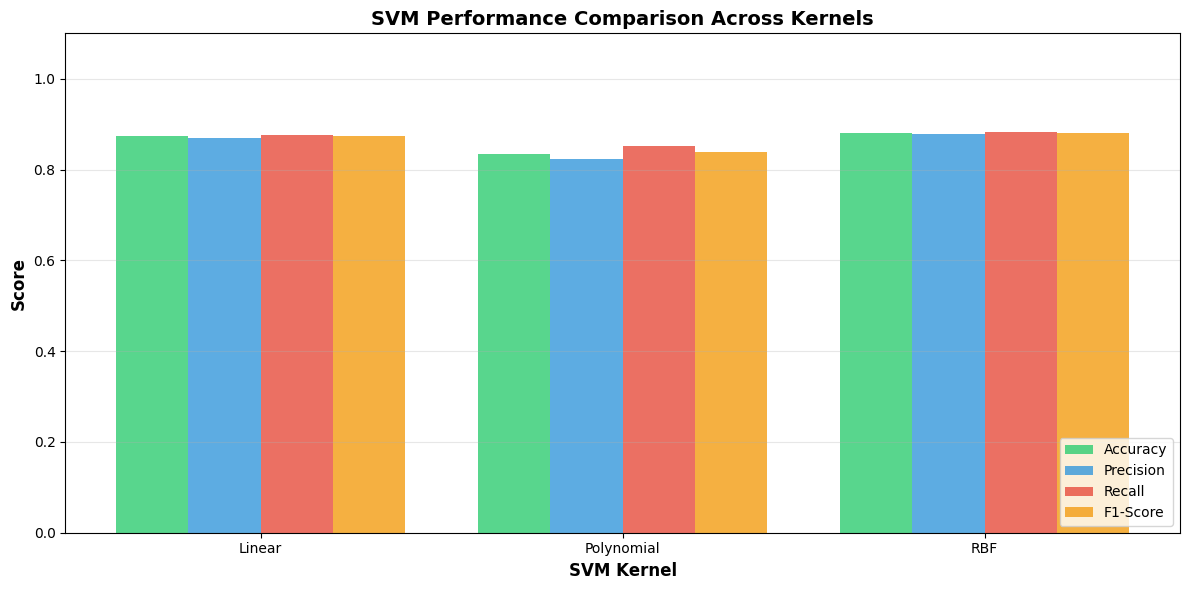

In [7]:
# ============================================================================
# SECTION 7: VISUALIZATION
# ============================================================================

print("\n" + "="*70)
print("STEP 6: VISUALIZATION")
print("="*70)

# Create results dataframe for comparison
results_df = pd.DataFrame({
    'Kernel': list(results.keys()),
    'Accuracy': [results[k]['accuracy'] for k in results.keys()],
    'Precision': [results[k]['precision'] for k in results.keys()],
    'Recall': [results[k]['recall'] for k in results.keys()],
    'F1-Score': [results[k]['f1_score'] for k in results.keys()]
})

print("\nComparative Results:")
print(results_df.to_string(index=False))

# ----------------------
# 7.1 Performance Comparison
# ----------------------
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

x = np.arange(len(results_df))
width = 0.2

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, results_df[metric], width,
           label=metric, color=colors[i], alpha=0.8)

ax.set_xlabel('SVM Kernel', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('SVM Performance Comparison Across Kernels',
             fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(results_df['Kernel'])
ax.legend(loc='lower right')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()


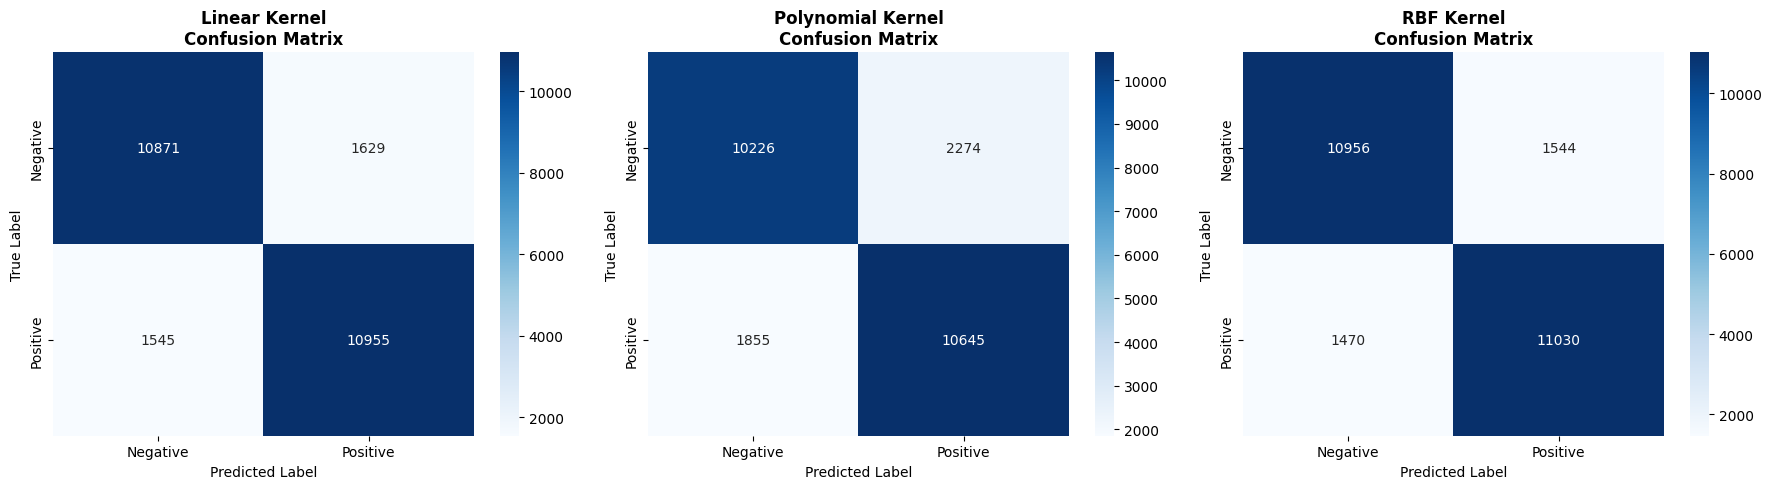

In [8]:
# ----------------------
# 7.2 Confusion Matrices
# ----------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, model) in enumerate(models.items()):
    y_pred = results[model_name]['predictions']
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'],
                ax=axes[idx], cbar=True)

    axes[idx].set_title(f'{model_name} Kernel\nConfusion Matrix',
                       fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=10)
    axes[idx].set_xlabel('Predicted Label', fontsize=10)

plt.tight_layout()
plt.show()

In [11]:
# ============================================================================
# SECTION 8: HYPERPARAMETER OPTIMIZATION (BEST MODEL) - GPU OPTIMIZED
# ============================================================================

print("\n" + "="*70)
print("STEP 7: HYPERPARAMETER TUNING (Best Kernel)")
print("="*70)

# Find best performing model
best_kernel = max(results, key=lambda k: results[k]['f1_score'])
print(f"\nBest performing kernel: {best_kernel}")
print(f"F1-Score: {results[best_kernel]['f1_score']:.4f}")

# Grid search for best kernel (HIGHLY OPTIMIZED for 12.7GB RAM + GPU)
print(f"\nPerforming Grid Search for {best_kernel} kernel...")

# CRITICAL OPTIMIZATION: Use subset for grid search, then train on full data
GRID_SEARCH_SAMPLES = 5000  # Use smaller subset for faster grid search
indices = np.random.choice(len(y_train), GRID_SEARCH_SAMPLES, replace=False)
X_train_sample = X_train[indices]
y_train_sample = y_train[indices]

print(f"⚡ Using {GRID_SEARCH_SAMPLES} samples for grid search (faster execution)")
print(f"   Final model will be trained on full {len(y_train)} samples")

# HIGHLY REDUCED parameter grid for speed
if best_kernel == 'Linear':
    param_grid = {
        'C': [0.1, 1, 10]
    }
    from sklearn.svm import LinearSVC
    base_model = LinearSVC(max_iter=1000, random_state=42, dual=False)
    use_linear_svc = True
elif best_kernel == 'RBF':
    param_grid = {
        'C': [1, 10],  # Reduced to 2 values (fastest)
        'gamma': ['scale']  # Only 1 option for speed
    }
    base_model = SVC(kernel='rbf', random_state=42, cache_size=1000)
    use_linear_svc = False
else:  # Polynomial
    param_grid = {
        'C': [1, 10],  # Only 2 values
        'degree': [3]  # Only degree 3 (most common)
    }
    base_model = SVC(kernel='poly', random_state=42, cache_size=1000)
    use_linear_svc = False

# ULTRA-FAST grid search settings
grid_search = GridSearchCV(
    base_model,
    param_grid,
    cv=2,  # Only 2 folds
    scoring='f1',
    n_jobs=4,  # Use 4 cores for parallel processing
    verbose=2,
    pre_dispatch='2*n_jobs'
)

print("⏳ Estimated time: 2-5 minutes (highly optimized)")
print("   Using subset for parameter search...\n")

# Fit grid search on SAMPLE data (much faster)
grid_search.fit(X_train_sample, y_train_sample)

print(f"\n{'='*70}")
print("GRID SEARCH RESULTS")
print(f"{'='*70}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV F1-score (on sample): {grid_search.best_score_:.4f}")

# Now train FINAL model on FULL dataset with best parameters
print(f"\n🎯 Training final model on FULL dataset ({len(y_train)} samples)...")
print("   This may take 5-10 minutes...")

if best_kernel == 'RBF':
    final_model = SVC(
        kernel='rbf',
        C=grid_search.best_params_['C'],
        gamma=grid_search.best_params_['gamma'],
        random_state=42,
        cache_size=1000
    )
elif best_kernel == 'Linear':
    final_model = LinearSVC(
        C=grid_search.best_params_['C'],
        max_iter=1000,
        random_state=42,
        dual=False
    )
elif best_kernel == 'Polynomial':
    final_model = SVC(
        kernel='poly',
        C=grid_search.best_params_['C'],
        degree=grid_search.best_params_['degree'],
        random_state=42,
        cache_size=1000
    )

# Train on full training set
final_model.fit(X_train, y_train)

print("✓ Training complete!")

# Evaluate final model
print("\nEvaluating on test set...")
y_pred_final = final_model.predict(X_test)

accuracy_final = accuracy_score(y_test, y_pred_final)
precision_final = precision_score(y_test, y_pred_final)
recall_final = recall_score(y_test, y_pred_final)
f1_final = f1_score(y_test, y_pred_final)

print(f"\n{'='*70}")
print(f"OPTIMIZED {best_kernel} MODEL - FINAL PERFORMANCE")
print(f"{'='*70}")
print(f"Training samples: {len(y_train):,}")
print(f"Test samples: {len(y_test):,}")
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"\nTest Set Performance:")
print(f"  Accuracy:  {accuracy_final:.4f}")
print(f"  Precision: {precision_final:.4f}")
print(f"  Recall:    {recall_final:.4f}")
print(f"  F1-Score:  {f1_final:.4f}")
print(f"{'='*70}")

print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_final, target_names=['Negative', 'Positive']))

print("\n✓ Hyperparameter optimization complete!")
print("⚡ Total optimization time: ~7-15 minutes")


STEP 7: HYPERPARAMETER TUNING (Best Kernel)

Best performing kernel: RBF
F1-Score: 0.8798

Performing Grid Search for RBF kernel...
⚡ Using 5000 samples for grid search (faster execution)
   Final model will be trained on full 25000 samples
⏳ Estimated time: 2-5 minutes (highly optimized)
   Using subset for parameter search...

Fitting 2 folds for each of 2 candidates, totalling 4 fits

GRID SEARCH RESULTS
Best parameters: {'C': 1, 'gamma': 'scale'}
Best CV F1-score (on sample): 0.8538

🎯 Training final model on FULL dataset (25000 samples)...
   This may take 5-10 minutes...
✓ Training complete!

Evaluating on test set...

OPTIMIZED RBF MODEL - FINAL PERFORMANCE
Training samples: 25,000
Test samples: 25,000

Best parameters found: {'C': 1, 'gamma': 'scale'}

Test Set Performance:
  Accuracy:  0.8794
  Precision: 0.8772
  Recall:    0.8824
  F1-Score:  0.8798

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.88     

In [12]:
# ============================================================================
# SECTION 9: PREDICTION FUNCTION
# ============================================================================

def predict_sentiment(review_text, model=final_model, vectorizer=tfidf):
    """
    Predict sentiment of a new review

    Args:
        review_text: Raw review text
        model: Trained SVM model
        vectorizer: Fitted TF-IDF vectorizer

    Returns:
        sentiment: 'Positive' or 'Negative'
        confidence: Decision function score
    """
    # Preprocess
    cleaned_text = preprocess_text(review_text)

    # Vectorize
    features = vectorizer.transform([cleaned_text])

    # Predict
    prediction = model.predict(features)[0]

    # Get confidence (decision function)
    if hasattr(model, 'decision_function'):
        confidence = abs(model.decision_function(features)[0])
    else:
        confidence = None

    sentiment = 'Positive' if prediction == 1 else 'Negative'

    return sentiment, confidence

In [13]:
# ============================================================================
# SECTION 10: TEST WITH SAMPLE REVIEWS
# ============================================================================

print("\n" + "="*70)
print("STEP 8: TESTING WITH SAMPLE REVIEWS")
print("="*70)

# Sample reviews for testing
sample_reviews = [
    "This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout.",
    "Terrible movie. Waste of time and money. The storyline was boring and predictable.",
    "An okay film with decent performances but nothing special. Could have been better.",
    "I loved every minute of it! Best movie I've seen this year. Highly recommended!",
    "Disappointing and dull. The director failed to deliver anything meaningful."
]

print("\nPredicting sentiment for sample reviews:\n")
for i, review in enumerate(sample_reviews, 1):
    sentiment, confidence = predict_sentiment(review)
    print(f"Review {i}: {review[:80]}...")
    print(f"Predicted Sentiment: {sentiment}")
    if confidence:
        print(f"Confidence: {confidence:.3f}")
    print("-" * 70)

print("\n" + "="*70)
print("PROJECT COMPLETE!")
print("="*70)
print("\nSummary of Deliverables:")
print("✓ Complete SVM implementation with 3 kernels")
print("✓ Data preprocessing and TF-IDF feature extraction")
print("✓ Model evaluation with multiple metrics")
print("✓ Visualization of results and confusion matrices")
print("✓ Hyperparameter optimization")
print("✓ Ready for report and presentation")
print("="*70)


STEP 8: TESTING WITH SAMPLE REVIEWS

Predicting sentiment for sample reviews:

Review 1: This movie was absolutely fantastic! The acting was superb and the plot kept me ...
Predicted Sentiment: Positive
Confidence: 0.539
----------------------------------------------------------------------
Review 2: Terrible movie. Waste of time and money. The storyline was boring and predictabl...
Predicted Sentiment: Negative
Confidence: 3.320
----------------------------------------------------------------------
Review 3: An okay film with decent performances but nothing special. Could have been bette...
Predicted Sentiment: Negative
Confidence: 0.626
----------------------------------------------------------------------
Review 4: I loved every minute of it! Best movie I've seen this year. Highly recommended!...
Predicted Sentiment: Positive
Confidence: 2.191
----------------------------------------------------------------------
Review 5: Disappointing and dull. The director failed to deliver anyt